In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,GlobalAvgPool2D,PReLU )
from tensorflow.keras.optimizers import Adam

# Prepare Data

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
B=24
LEARNING_RATE = 1e-4

In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/celeba_hq_256", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 30000 files belonging to 1 classes.


In [ ]:
def preprocess(image):
  return tf.image.resize(image,[IM_SHAPE[0]//4,IM_SHAPE[1]//4],method='bicubic')/255,tf.cast(image,tf.float32)/127.5 - 1.0

In [ ]:
ds

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
train_dataset = (
    ds.take(12000)
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d1,d2 in train_dataset.take(1):
  print(d1.shape,d2.shape)

(128, 16, 16, 3) (128, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


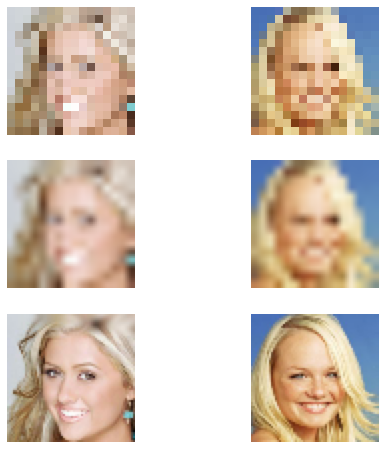

In [ ]:
plt.figure(figsize = (8,8))
k=0
n = 6
for i in range(n):
    ax = plt.subplot(3,2, k+1)
    if i<2:
      plt.imshow(d1[i])
    elif i>=2 and i<4:
      plt.imshow(cv2.resize(np.array(d1[i-2]),(64,64)))
    else:
      plt.imshow((d2[i-4]+1)/2)
    plt.axis("off")
    k+=1

# MOdeling

In [ ]:
class ResBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='res_block'):
      super(ResBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv_1=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm_1=BatchNormalization()
      self.prelu=PReLU()
      self.conv_2=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm_2=BatchNormalization()

    def call(self,x_in):
      x=self.conv_1(x_in)
      x=self.prelu(self.batch_norm_1(x))
      x=self.conv_2(x)
      x=self.batch_norm_2(x)
      return x+x_in

In [ ]:
class UpsampleBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='upsample_block'):
      super(UpsampleBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.prelu=PReLU()
    def call(self,x):
      x=self.conv(x)
      x=tf.nn.depth_to_space(x, 2)
      x=self.prelu(x)
      return x

In [ ]:
input_lr=tf.keras.layers.Input(shape=(IM_SHAPE[0]//4,IM_SHAPE[1]//4,3))
input_conv=tf.keras.layers.Conv2D(64,9,1,padding='same')(input_lr)
input_conv=PReLU()(input_conv)

x=input_conv
for i in range(B):
  x=ResBlock(64,3,1,name='res_block_'+str(i))(x)

x=tf.keras.layers.Conv2D(64,9,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)

x+=input_conv

x=UpsampleBlock(256,3,1,name='upsample_block_1')(x)
x=UpsampleBlock(256,3,1,name='upsample_block_2')(x)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(x)

srresnet=tf.keras.models.Model(input_lr,output_sr)
srresnet.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 64)   15616       ['input_9[0][0]']                
                                                                                                  
 p_re_lu_5 (PReLU)              (None, 16, 16, 64)   16384       ['conv2d_15[0][0]']              
                                                                                                  
 res_block_0 (ResBlock)         (None, 16, 16, 64)   90752       ['p_re_lu_5[0][0]']              
                                                                                            

In [ ]:
class ConvBlock(Layer):
    def __init__(self,n_filters,filter_size,strides,name='conv_block'):
      super(ConvBlock, self).__init__(name=name)
      self.n_filters=n_filters
      self.filter_size=filter_size
      self.strides=strides

    def build(self,input_shape):
      self.conv=Conv2D(
          self.n_filters,self.filter_size,strides=self.strides,padding='same')
      self.batch_norm=BatchNormalization()

    def call(self,x):
      x=self.conv(x)
      x=LeakyReLU()(self.batch_norm(x))
      return x

In [ ]:
input_lr=tf.keras.layers.Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for i in range(7):
  disc=ConvBlock(
      channel_nums[i],3,stride_sizes[i],name='conv_block_'+str(i))(disc)
disc = GlobalAvgPool2D()(disc)
disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)
discriminator.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv_block_0 (ConvBlock)    (None, 32, 32, 64)        37184     
                                                                 
 conv_block_1 (ConvBlock)    (None, 32, 32, 128)       74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 16, 16, 128)       148096    
                                                                 
 conv_block_3 (ConvBlock)    (None, 16, 16, 256)       2961

In [ ]:
def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

In [ ]:
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break

    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      mse=tf.keras.losses.MeanSquaredError(name='mean_squared_error')
      accumulated_loss+=mse(y_hr,y_sr)*0.006

  return accumulated_loss

In [ ]:
def content_loss(y_true,y_pred):
  mse=tf.keras.losses.MeanSquaredError(name='mean_squared_error')
  return mse(y_true,y_pred)+VGG_loss(y_true,y_pred)

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch,logs=None):
    plt.figure(figsize = (16,16))
    k=0
    n = 6
    for i in range(n):
      ax = plt.subplot(3,2, k+1)
      if i<2:
        plt.imshow(d1[i])
      elif i>=2 and i<4:
        out=self.model.generator(tf.expand_dims(d1[i-2],axis=0))
        plt.imshow((out[0]+1)/2)
      else:
        plt.imshow((d2[i-4]+1)/2)
      plt.axis("off")
      k+=1

    plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))


In [ ]:
class SRGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_disc,loss_gen,):
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_disc=loss_disc
        self.loss_gen=loss_gen
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

      lr_images,hr_images = real_images

      batch_size = tf.shape(hr_images)[0]

      generated_images = self.generator(lr_images)

      real_labels = tf.ones((batch_size, 1))
      fake_labels = tf.zeros((batch_size, 1))

      # Train the discriminator
      with tf.GradientTape() as tape:

          real_predictions = self.discriminator(hr_images)
          d_loss_real = self.loss_disc(real_labels,real_predictions)

          fake_predictions = self.discriminator(generated_images)
          d_loss_fake = self.loss_disc(fake_labels,fake_predictions)

          d_loss = 0.5*(d_loss_fake+d_loss_real)
      grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

      misleading_labels = tf.ones((batch_size, 1))

      with tf.GradientTape() as tape:
          predictions = self.generator(lr_images)
          g_loss = self.loss_gen(hr_images, predictions)
          g_loss=g_loss+1e-3*self.loss_disc(misleading_labels, self.discriminator(predictions))

      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

      # Update metrics
      self.d_loss_metric.update_state(d_loss)
      self.g_loss_metric.update_state(g_loss)
      return {
          "d_loss": self.d_loss_metric.result(),
          "g_loss": self.g_loss_metric.result(),
      }

In [ ]:
epochs = 36

gan = SRGAN(discriminator=discriminator, generator=srresnet, )
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_disc=tf.keras.losses.BinaryCrossentropy(),
    loss_gen=content_loss,
)

In [ ]:
!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
history=gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor()]
)

Epoch 1/36
    234/Unknown - 110s 421ms/step - d_loss: 0.5162 - g_loss: 0.3425

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 110s 422ms/step - d_loss: 0.5162 - g_loss: 0.3425
Epoch 2/36
234/234 [==============================] - ETA: 0s - d_loss: 0.1222 - g_loss: 0.2139

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.1222 - g_loss: 0.2139
Epoch 3/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0533 - g_loss: 0.1872

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0533 - g_loss: 0.1872
Epoch 4/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0481 - g_loss: 0.1729

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0481 - g_loss: 0.1729
Epoch 5/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0393 - g_loss: 0.1641

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0393 - g_loss: 0.1641
Epoch 6/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0332 - g_loss: 0.1566

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 424ms/step - d_loss: 0.0332 - g_loss: 0.1566
Epoch 7/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0203 - g_loss: 0.1519

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0203 - g_loss: 0.1519
Epoch 8/36
234/234 [==============================] - ETA: 0s - d_loss: 0.2558 - g_loss: 0.1463

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.2558 - g_loss: 0.1463
Epoch 9/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0491 - g_loss: 0.1431

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0491 - g_loss: 0.1431
Epoch 10/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0256 - g_loss: 0.1396

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0256 - g_loss: 0.1396
Epoch 11/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0434 - g_loss: 0.1370

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0434 - g_loss: 0.1370
Epoch 12/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0315 - g_loss: 0.1357

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0315 - g_loss: 0.1357
Epoch 13/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0339 - g_loss: 0.1332

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0339 - g_loss: 0.1332
Epoch 14/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0305 - g_loss: 0.1325

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0305 - g_loss: 0.1325
Epoch 15/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0527 - g_loss: 0.1296

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0527 - g_loss: 0.1296
Epoch 16/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0322 - g_loss: 0.1279

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0322 - g_loss: 0.1279
Epoch 17/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0391 - g_loss: 0.1275

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0391 - g_loss: 0.1275
Epoch 18/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0449 - g_loss: 0.1257

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0449 - g_loss: 0.1257
Epoch 19/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0373 - g_loss: 0.1247

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0373 - g_loss: 0.1247
Epoch 20/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0444 - g_loss: 0.1244

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0444 - g_loss: 0.1244
Epoch 21/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0492 - g_loss: 0.1237

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0492 - g_loss: 0.1237
Epoch 22/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0512 - g_loss: 0.1225

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0512 - g_loss: 0.1225
Epoch 23/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0489 - g_loss: 0.1232

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0489 - g_loss: 0.1232
Epoch 24/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0460 - g_loss: 0.1215

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 422ms/step - d_loss: 0.0460 - g_loss: 0.1215
Epoch 25/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0431 - g_loss: 0.1210

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 424ms/step - d_loss: 0.0431 - g_loss: 0.1210
Epoch 26/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0365 - g_loss: 0.1202

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0365 - g_loss: 0.1202
Epoch 27/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0393 - g_loss: 0.1196

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0393 - g_loss: 0.1196
Epoch 28/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0400 - g_loss: 0.1194

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0400 - g_loss: 0.1194
Epoch 29/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0399 - g_loss: 0.1184

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 101s 426ms/step - d_loss: 0.0399 - g_loss: 0.1184
Epoch 30/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0385 - g_loss: 0.1179

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0385 - g_loss: 0.1179
Epoch 31/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0412 - g_loss: 0.1174

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0412 - g_loss: 0.1174
Epoch 32/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0473 - g_loss: 0.1168

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0473 - g_loss: 0.1168
Epoch 33/36
234/234 [==============================] - ETA: 0s - d_loss: 0.2541 - g_loss: 0.2220

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.2541 - g_loss: 0.2220
Epoch 34/36
234/234 [==============================] - ETA: 0s - d_loss: 0.1282 - g_loss: 0.1244

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.1282 - g_loss: 0.1244
Epoch 35/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0851 - g_loss: 0.1190

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0851 - g_loss: 0.1190
Epoch 36/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0796 - g_loss: 0.1172

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


234/234 [==============================] - 100s 423ms/step - d_loss: 0.0796 - g_loss: 0.1172


In [ ]:

gan.generator.save('srgan_generator.h5')

gan.discriminator.save('srgan_discriminator.h5')

In [ ]:
def generate_sr_images(lr_images):
    return gan.generator.predict(lr_images)

test_images = next(iter(train_dataset))[0][:4]
generated_images = generate_sr_images(test_images)

plt.figure(figsize=(16,8))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow((test_images[i] + 1)/2)
    plt.axis('off')
    plt.title('Low Resolution')
    
    plt.subplot(2,4,i+5)
    plt.imshow((generated_images[i] + 1)/2) 
    plt.axis('off')
    plt.title('Generated SR')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.title('Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

test_hr_images = next(iter(train_dataset))[1][:4]
psnr = PSNR(test_hr_images, generated_images)
print(f"Average PSNR: {tf.reduce_mean(psnr):.2f}")

In [ ]:
loaded_generator = tf.keras.models.load_model('srgan_generator.h5')
loaded_discriminator = tf.keras.models.load_model('srgan_discriminator.h5')

loaded_gan = SRGAN(
    discriminator=loaded_discriminator,
    generator=loaded_generator
)

In [ ]:
def process_custom_image(image_path, target_size=(64,64)):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.image.resize(img, target_size)
    img = (img - 127.5) / 127.5
    return tf.expand_dims(img, 0)

custom_lr = process_custom_image('test_image.jpg')
custom_sr = gan.generator.predict(custom_lr)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow((custom_lr[0] + 1)/2)
plt.title('Input LR')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow((custom_sr[0] + 1)/2)
plt.title('Generated SR')
plt.axis('off')
plt.show()